In [56]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(3, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 128)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc6(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(130, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x= F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

class Aggregator(nn.Module):
    def __init__(self):
        super(Aggregator, self).__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=0)

class cnp(nn.Module):
    def __init__(self):
        super(cnp, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.aggregator = Aggregator()
        
    def forward(self, contextx, contexty, targetx):
        context = torch.cat([contextx, contexty.view(-1, 1)], dim=1)
        encoded_context = self.encoder(context)
        aggregated = self.aggregator(encoded_context)
        decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, 2)], dim=1)
        output = self.decoder(decoder_input)
        return output



In [4]:
#upload mnist data
import tensorflow as tf
(trainx, trainy), (testx, testy) = tf.keras.datasets.mnist.load_data()
# trainx=trainx/255

In [5]:

model2=cnp()
model2.load_state_dict(torch.load("./mnist.pth"))
criterion= nn.MSELoss()
optimizer=optim.Adam(model2.parameters(), lr=0.001)
# trainx=trainx/255
# print(trainx[image_index])

In [ ]:
from tqdm import tqdm
num_epochs=1
for i in tqdm(range(100000)):
    image_index=np.random.randint(0, 100)
    # plt.imshow(trainx[image_index].flatten().reshape(28,28), cmap='gray')
    for epoch in (range(num_epochs)):

        image=trainx[image_index]
        # print(image.shape)
        x1 = np.random.choice(28, 300)
        x2 = np.random.choice(28, 300)
        context_x = np.column_stack((x1, x2))
        context_y = image[context_x[:, 1], context_x[:, 0]].reshape(-1, 1)
        
        
        x1, x2 = np.meshgrid(np.arange(28), np.arange(28))
        target_x= np.column_stack((x1.reshape(-1), x2.reshape(-1)))
        target_y= image[target_x[:, 1], target_x[:, 0]].reshape(-1, 1)

        context_x = torch.tensor(context_x, dtype=torch.float32)
        context_y = torch.tensor(context_y, dtype=torch.float32)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32)

        # target_x=target_x/
        # context_x=context_x/784
        

        optimizer.zero_grad()
        predictions = model2(context_x, context_y, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}")


 59%|█████▉    | 59091/100000 [06:00<04:09, 163.99it/s]


In [5]:
path='./mnist.pth'
torch.save(model2.state_dict(), path)


Text(0.5, 1.0, 'Prediction')

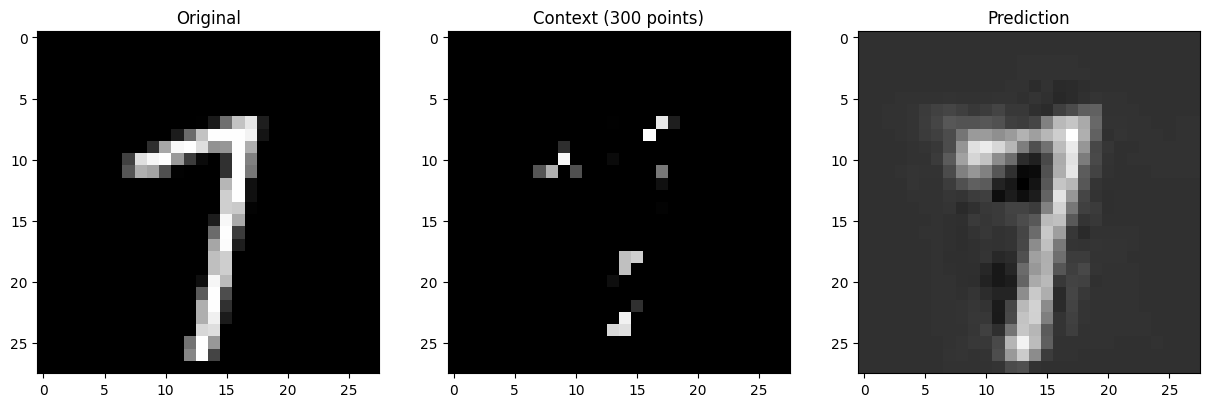

In [122]:
image=trainx[np.random.randint(0, 100)]
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(image, cmap='gray')
x1 = np.random.choice(28, 300)
x2 = np.random.choice(28, 300)
context_x = np.column_stack((x1, x2))
context_y = image[context_x[:, 1], context_x[:, 0]].reshape(-1, 1)


x1, x2 = np.meshgrid(np.arange(28), np.arange(28))
target_x= np.column_stack((x1.reshape(-1), x2.reshape(-1)))
target_y= image[target_x[:, 1], target_x[:, 0]].reshape(-1, 1)

context_x = torch.tensor(context_x, dtype=torch.float32)
context_y = torch.tensor(context_y, dtype=torch.float32)
target_x = torch.tensor(target_x, dtype=torch.float32)
target_y = torch.tensor(target_y, dtype=torch.float32)

# target_x=target_x/
# context_x=context_x/784


image_context=np.zeros((28,28))
for i in range(len(context_x)):
    image_context[int(context_x[i][1])][int(context_x[i][0])]=context_y[i]
axs[1].imshow(image_context, cmap='gray')


#plot the prediction
predictions = model2(context_x, context_y, target_x)
axs[2].imshow(predictions.detach().numpy().reshape(28,28), cmap='gray')
axs[1].set_title("Context (300 points)")
axs[0].set_title("Original")
axs[2].set_title("Prediction")